Using device: cpu


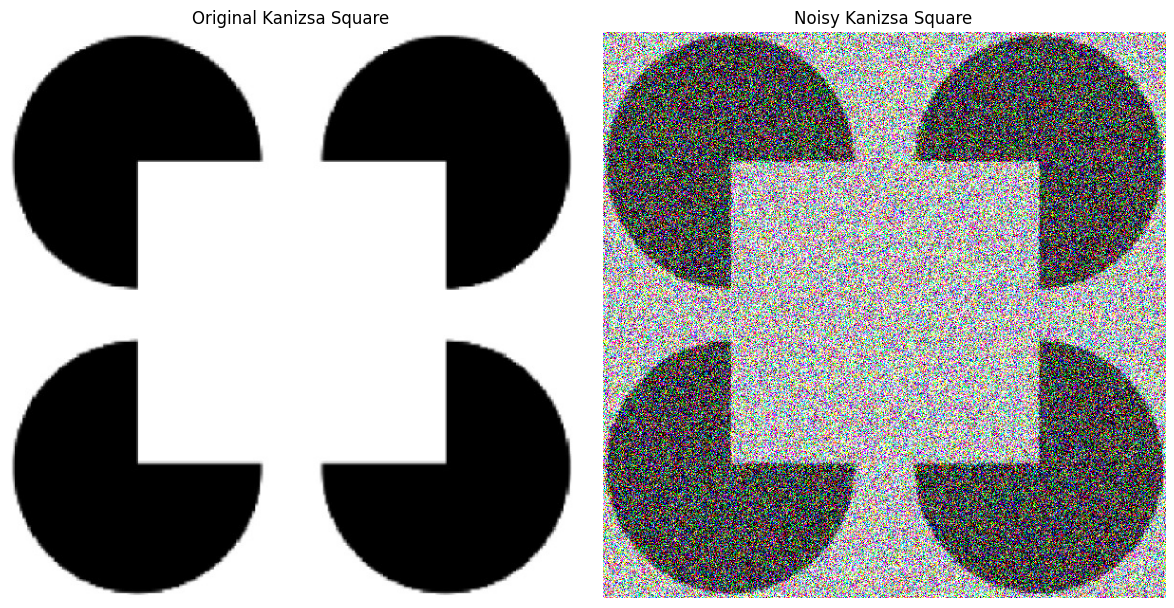

Layer4 Representation for Original Image:


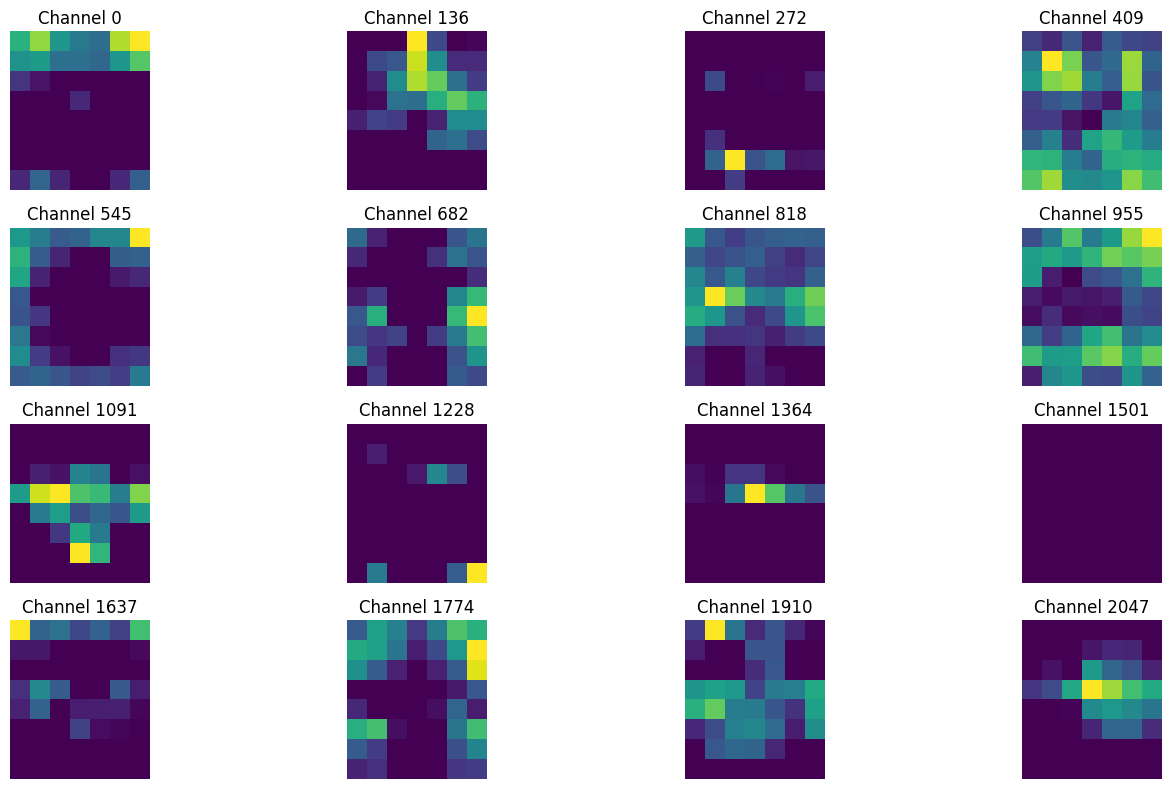

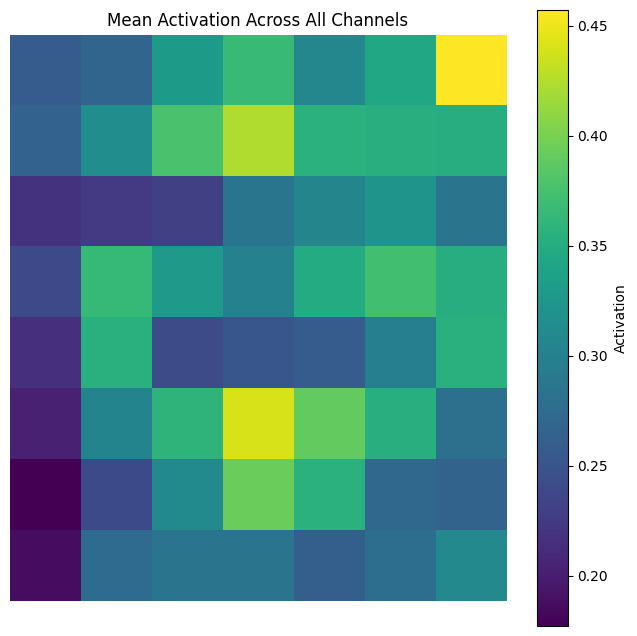

Layer4 Representation for Noisy Image:


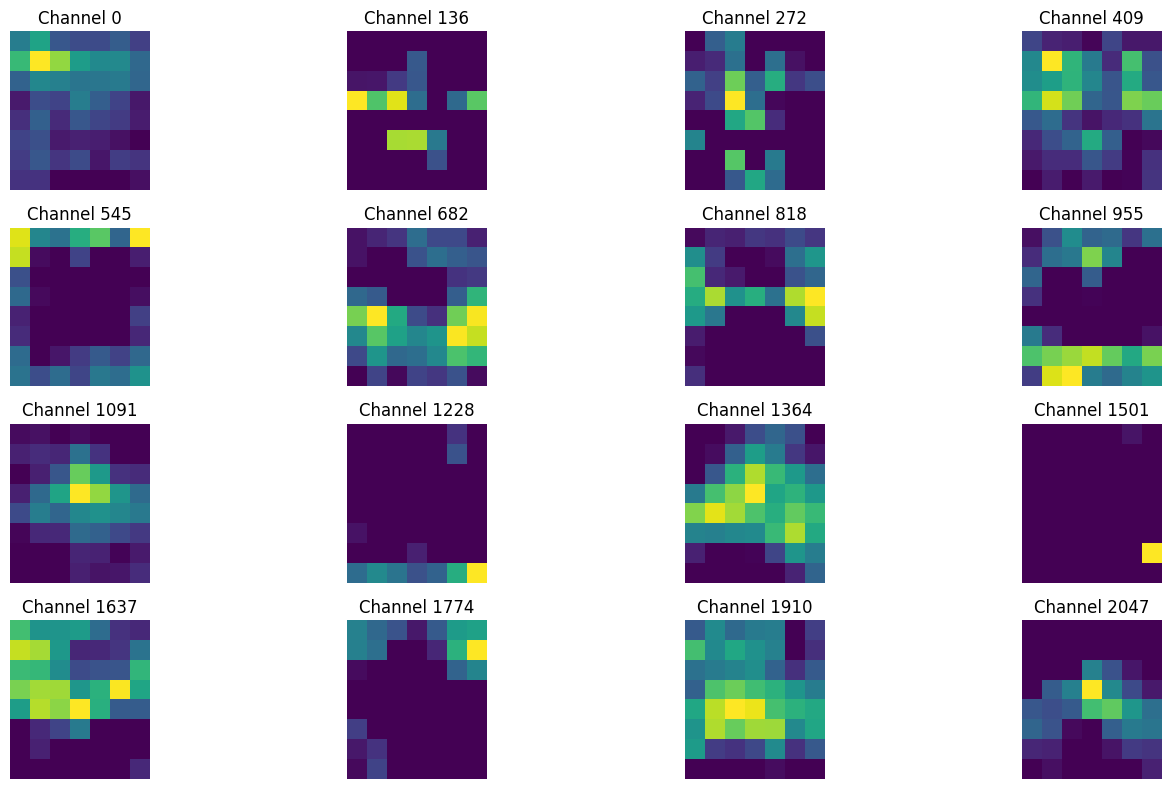

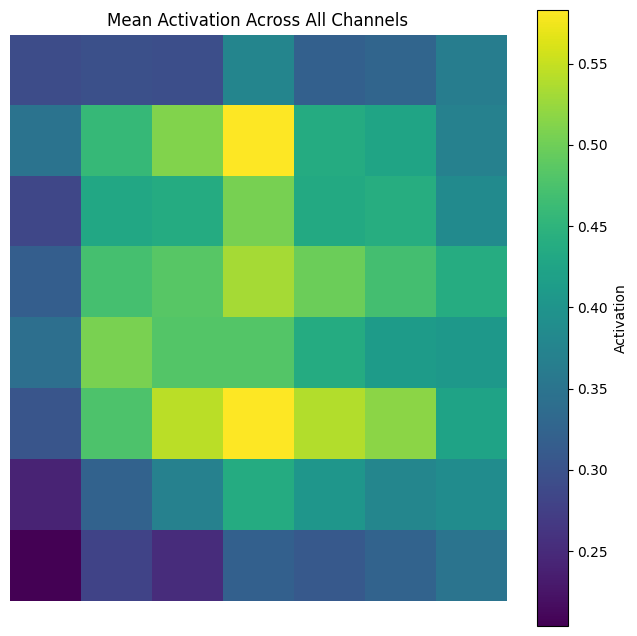

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def add_noise(image, noise_level=0.2):
    """Add Gaussian noise to an image"""
    # Convert PIL Image to numpy array
    img_array = np.array(image).astype(float) / 255.0
    
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_level, img_array.shape)
    
    # Add noise to the image
    noisy_array = np.clip(img_array + noise, 0, 1)
    
    # Convert back to PIL Image
    noisy_image = Image.fromarray((noisy_array * 255).astype(np.uint8))
    
    return noisy_image

def extract_layer_representation(model, layer_name, input_tensor):
    """Extract representation from a specific layer in the model"""
    # Dictionary to store the activations
    activations = {}
    
    def hook_fn(module, input, output):
        activations['output'] = output
    
    # Register the forward hook on the target layer
    if layer_name == 'layer4':
        hook = model.layer4.register_forward_hook(hook_fn)
    else:
        raise ValueError(f"Layer {layer_name} not supported")
    
    # Forward pass
    with torch.no_grad():
        model(input_tensor)
    
    # Remove the hook
    hook.remove()
    
    return activations['output']

def visualize_representation(representation, num_channels=16, figsize=(15, 8)):
    """Visualize activation maps from a given layer representation"""
    # Get a subset of channels to visualize
    batch_size, channels, height, width = representation.size()
    
    # Compute the mean activation across all channels
    mean_activation = representation.mean(dim=1)[0].cpu().numpy()
    
    # Get some individual channels
    channels_to_show = np.linspace(0, channels-1, num_channels, dtype=int)
    
    # Create a figure to display activations
    fig, axes = plt.subplots(4, 4, figsize=figsize)
    axes = axes.flatten()
    
    # Plot individual channels
    for i, channel_idx in enumerate(channels_to_show):
        if i < num_channels:
            channel_data = representation[0, channel_idx].cpu().numpy()
            axes[i].imshow(channel_data, cmap='viridis')
            axes[i].set_title(f'Channel {channel_idx}')
            axes[i].axis('off')
    
    plt.tight_layout()
    
    # Plot the mean activation in a separate figure
    plt.figure(figsize=(8, 8))
    plt.imshow(mean_activation, cmap='viridis')
    plt.title('Mean Activation Across All Channels')
    plt.axis('off')
    plt.colorbar(label='Activation')
    
    plt.show()

# Main procedure
def main():
    # Load your Kanizsa square image
    # Replace 'path_to_your_kanizsa_image.jpg' with the actual path to your file
    kanizsa_img_path = './Stimuli/Kanizsa_square.jpg'
    kanizsa_img = Image.open(kanizsa_img_path).convert('RGB')
    
    # Add noise to the image
    noisy_img = add_noise(kanizsa_img, noise_level=0.9)
    
    # Define transform for the model
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load pre-trained ResNet50 model
    model = models.resnet50(pretrained=True)
    model.eval()
    
    # Check for GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Using device: {device}")
    
    # Prepare images for the model
    input_tensor_original = transform(kanizsa_img).unsqueeze(0).to(device)
    input_tensor_noisy = transform(noisy_img).unsqueeze(0).to(device)
    
    # Extract layer4 representations
    layer4_rep_original = extract_layer_representation(model, 'layer4', input_tensor_original)
    layer4_rep_noisy = extract_layer_representation(model, 'layer4', input_tensor_noisy)
    
    # Display the images and their representations
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(kanizsa_img)
    plt.title('Original Kanizsa Square')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_img)
    plt.title('Noisy Kanizsa Square')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Layer4 Representation for Original Image:")
    visualize_representation(layer4_rep_original)
    
    print("Layer4 Representation for Noisy Image:")
    visualize_representation(layer4_rep_noisy)

if __name__ == "__main__":
    main()

Using device: cpu


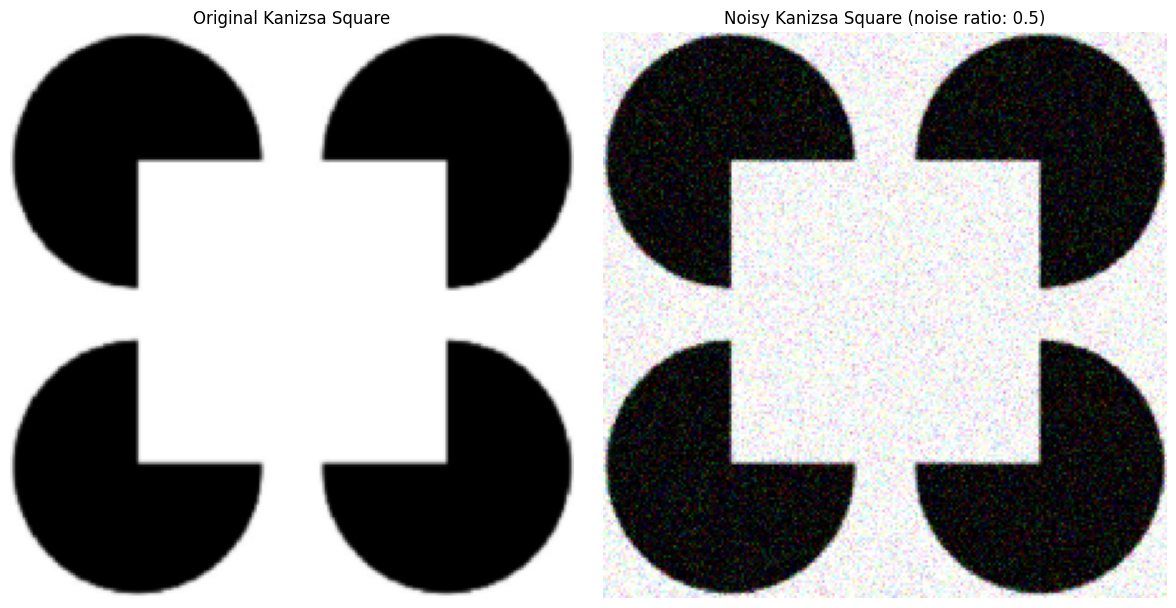

Comparing Channel 42 of Layer4 Representation:


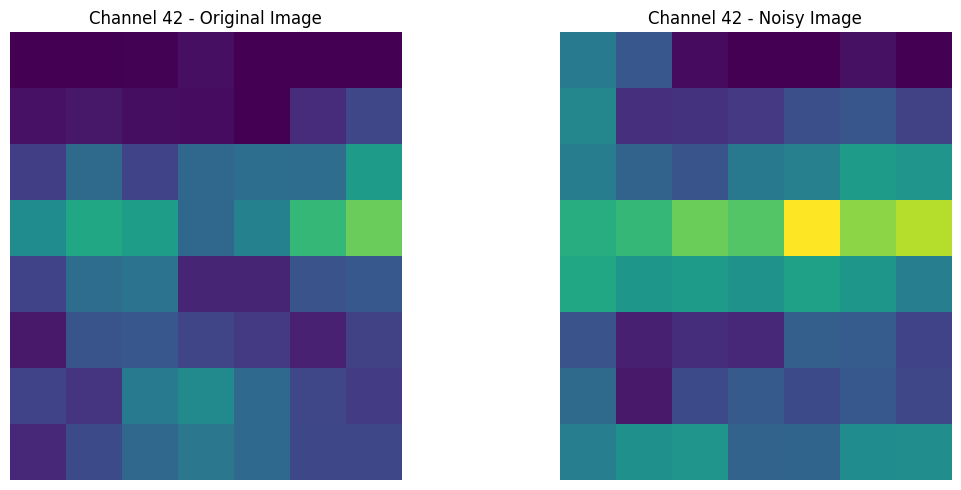

Comparing Multiple Channels of Layer4 Representation:


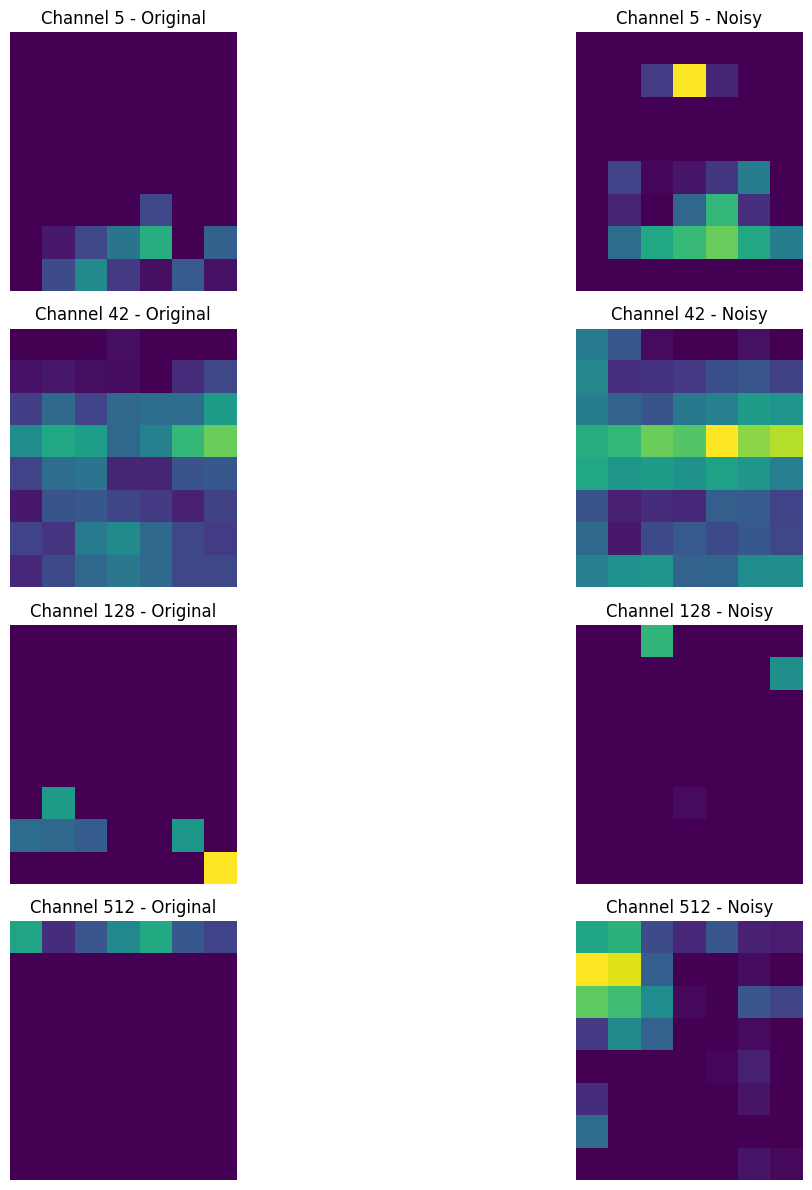

Channels most affected by noise (lowest correlation):


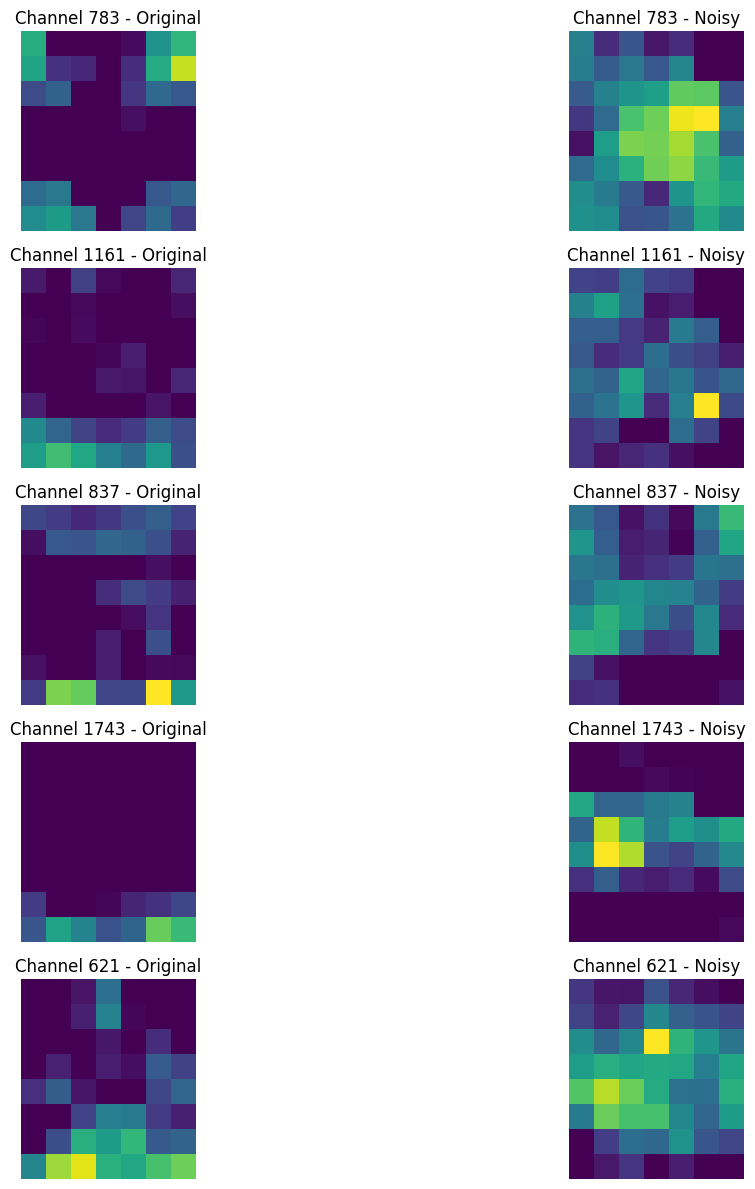

Channels least affected by noise (highest correlation):


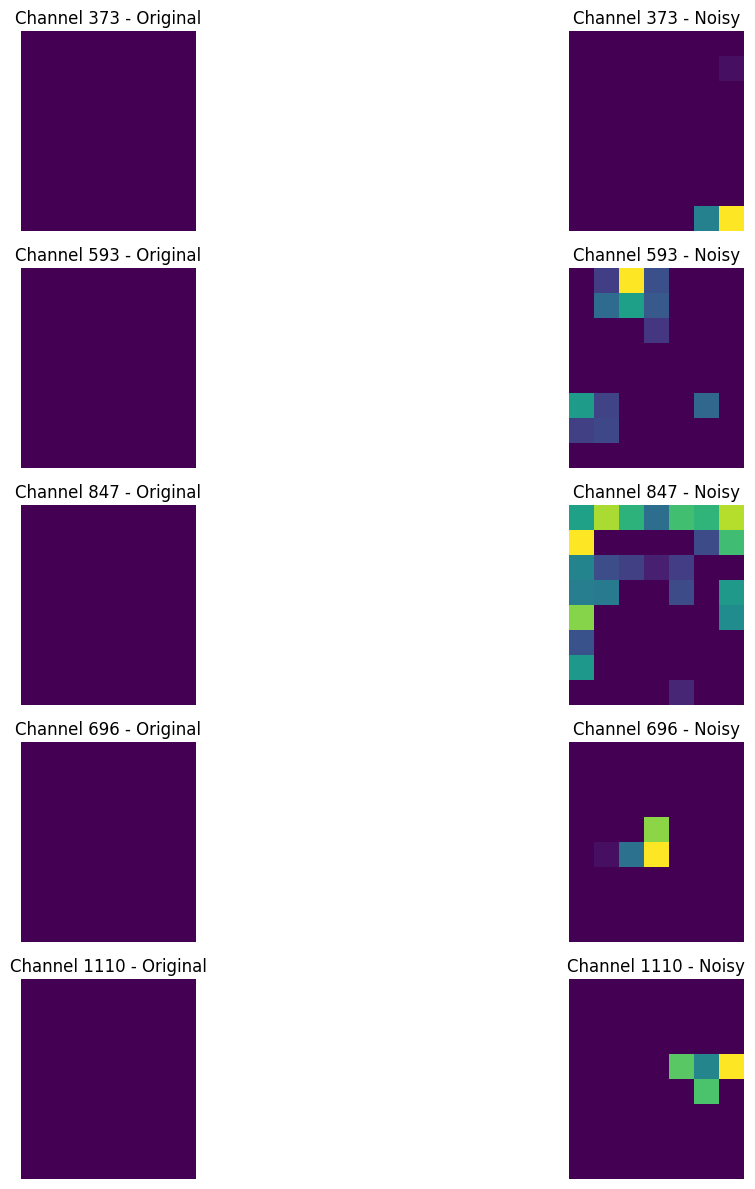

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def extract_layer_representation(model, layer_name, input_tensor):
    """Extract representation from a specific layer in the model"""
    # Dictionary to store the activations
    activations = {}
    
    def hook_fn(module, input, output):
        activations['output'] = output
    
    # Register the forward hook on the target layer
    if layer_name == 'layer4':
        hook = model.layer4.register_forward_hook(hook_fn)
    else:
        raise ValueError(f"Layer {layer_name} not supported")
    
    # Forward pass
    with torch.no_grad():
        model(input_tensor)
    
    # Remove the hook
    hook.remove()
    
    return activations['output']

def visualize_specific_channel(representation_original, representation_noisy, channel_idx=0, figsize=(12, 5)):
    """Visualize a specific channel from both original and noisy image representations side by side"""
    # Extract the data for the specified channel
    channel_data_original = representation_original[0, channel_idx].cpu().numpy()
    channel_data_noisy = representation_noisy[0, channel_idx].cpu().numpy()
    
    # Calculate common min and max for consistent color mapping
    vmin = min(channel_data_original.min(), channel_data_noisy.min())
    vmax = max(channel_data_original.max(), channel_data_noisy.max())
    
    # Create a figure for side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot original image representation
    im0 = axes[0].imshow(channel_data_original, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Channel {channel_idx} - Original Image')
    axes[0].axis('off')
    
    # Plot noisy image representation
    im1 = axes[1].imshow(channel_data_noisy, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Channel {channel_idx} - Noisy Image')
    axes[1].axis('off')
    
    # # Add colorbar
    # plt.colorbar(im1, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_channels(representation_original, representation_noisy, channels=[0, 10, 50, 100], figsize=(15, 12)):
    """Visualize multiple specified channels from both original and noisy image representations"""
    # Number of channels to display
    n_channels = len(channels)
    
    # Create a figure for side-by-side comparison with multiple channels
    fig, axes = plt.subplots(n_channels, 2, figsize=figsize)
    
    for i, channel_idx in enumerate(channels):
        # Extract the data for the specified channel
        channel_data_original = representation_original[0, channel_idx].cpu().numpy()
        channel_data_noisy = representation_noisy[0, channel_idx].cpu().numpy()
        
        # Calculate common min and max for consistent color mapping
        vmin = min(channel_data_original.min(), channel_data_noisy.min())
        vmax = max(channel_data_original.max(), channel_data_noisy.max())
        
        # Plot original image representation
        im0 = axes[i, 0].imshow(channel_data_original, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[i, 0].set_title(f'Channel {channel_idx} - Original')
        axes[i, 0].axis('off')
        
        # Plot noisy image representation
        im1 = axes[i, 1].imshow(channel_data_noisy, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[i, 1].set_title(f'Channel {channel_idx} - Noisy')
        axes[i, 1].axis('off')
        
        # # Add colorbar
        # plt.colorbar(im1, ax=axes[i, :], orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def tensor_to_pil(tensor):
    """Convert a normalized tensor to PIL Image for display"""
    # Clone the tensor to avoid modifying the original
    img = tensor.clone().cpu().squeeze(0)
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    
    # Clamp values to [0, 1]
    img = torch.clamp(img, 0, 1)
    
    # Convert to PIL
    img = transforms.ToPILImage()(img)
    return img

# Main procedure
def main():
    # Load your Kanizsa square image
    kanizsa_img_path = './Stimuli/Kanizsa_square.jpg'
    kanizsa_img = Image.open(kanizsa_img_path).convert('RGB')
    
    # Define transform for the model
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load pre-trained ResNet50 model
    model = models.resnet50(pretrained=True)
    model.eval()
    
    # Check for GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Using device: {device}")
    
    # Prepare image tensor
    image_tensor = transform(kanizsa_img).unsqueeze(0).to(device)
    
    # Add noise directly to the tensor
    initial_inference_noise_ratio = 0.5  # You can adjust this value
    added_noise = initial_inference_noise_ratio * torch.randn_like(image_tensor).to(device)
    noisy_image_tensor = image_tensor + added_noise
    
    # Extract layer4 representations
    layer4_rep_original = extract_layer_representation(model, 'layer4', image_tensor)
    layer4_rep_noisy = extract_layer_representation(model, 'layer4', noisy_image_tensor)
    
    # Convert tensors back to PIL images for display
    original_pil = tensor_to_pil(image_tensor)
    noisy_pil = tensor_to_pil(noisy_image_tensor)
    
    # Display the images first
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_pil)
    plt.title('Original Kanizsa Square')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_pil)
    plt.title(f'Noisy Kanizsa Square (noise ratio: {initial_inference_noise_ratio})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Choose a specific channel to visualize (you can change this value)
    specific_channel = 42  # Example channel index
    
    # Visualize the specific channel for both original and noisy image
    print(f"Comparing Channel {specific_channel} of Layer4 Representation:")
    visualize_specific_channel(layer4_rep_original, layer4_rep_noisy, specific_channel)
    
    # Visualize a set of interesting channels
    interesting_channels = [5, 42, 128, 512]  # Example channel indices
    print(f"Comparing Multiple Channels of Layer4 Representation:")
    visualize_multiple_channels(layer4_rep_original, layer4_rep_noisy, interesting_channels)
    
    # Compute the correlation between original and noisy representations for each channel
    correlations = []
    for i in range(layer4_rep_original.size(1)):  # Loop through all channels
        channel_orig = layer4_rep_original[0, i].cpu().numpy().flatten()
        channel_noisy = layer4_rep_noisy[0, i].cpu().numpy().flatten()
        corr = np.corrcoef(channel_orig, channel_noisy)[0, 1]
        correlations.append(corr)
    
    # Identify channels with the highest and lowest correlation
    sorted_indices = np.argsort(correlations)
    lowest_corr_channels = sorted_indices[:5]  # 5 channels with lowest correlation
    highest_corr_channels = sorted_indices[-5:]  # 5 channels with highest correlation
    
    print("Channels most affected by noise (lowest correlation):")
    visualize_multiple_channels(layer4_rep_original, layer4_rep_noisy, lowest_corr_channels)
    
    print("Channels least affected by noise (highest correlation):")
    visualize_multiple_channels(layer4_rep_original, layer4_rep_noisy, highest_corr_channels)
    
if __name__ == "__main__":
    main()